# Quadratic Assignment Problem

#### Problem Description

The goal of the Quadratic Assignment Problem (QAP) is to assign 𝑁 facilities to 𝑁 locations so that assignment costs are minimized.
The assignment costs are defined by a function that multiplies and summarizes the flow/demand (f) and distance (d) for each assignment

In [3]:
from dwave_qbsolv import QBSolv
from dwave.system import FixedEmbeddingComposite, DWaveSampler
import dwave.inspector
from dimod import qubo_to_ising
from minorminer import minorminer
import networkx as nx
from FileParser import FileParser
import string
import numpy as np

#### Setup Problem

In [4]:
path_to_file = "./"
file_name = "test_instance_5.dat"
file_parser = FileParser(path_to_file, file_name)
flows, distances, num_nodes = file_parser.parse_file()

print("Distances:\n", distances)
print("Flows: \n", flows)
print("Number of nodes:", num_nodes)

Distances:
 [[ 0 32 68 97 75]
 [32  0 42 80 53]
 [68 42  0 45 15]
 [97 80 45  0 30]
 [75 53 15 30  0]]
Flows: 
 [[0 2 4 0 0]
 [2 0 3 1 0]
 [4 3 0 0 0]
 [0 1 0 0 1]
 [0 0 0 1 0]]
Number of nodes: 5


In [8]:
# Facility to location mapping. Used for decoding quantum annealing response
facility_to_location = []
for i in range(num_nodes):
    for j in range(num_nodes):
        facility_to_location.append(string.ascii_uppercase[i] + str(j))
print("Facility to location:", facility_to_location)

Facility to location: ['A0', 'A1', 'A2', 'A3', 'A4', 'B0', 'B1', 'B2', 'B3', 'B4', 'C0', 'C1', 'C2', 'C3', 'C4', 'D0', 'D1', 'D2', 'D3', 'D4', 'E0', 'E1', 'E2', 'E3', 'E4']


#### Build QUBO

In [9]:
length_of_QUBO = num_nodes**2
prefactor = distances.max() * flows.max() + 1
QUBO = {}

In [10]:
# Fill upper triangular QUBO Matrix
for v in range(0, length_of_QUBO):
    for j in range(v, length_of_QUBO):
        QUBO[(v, j)] = 0.0

In [11]:
# Optimization Function (add distances and flows)
# Add distances
dist_x = 0
dist_y = 0
for v in range(0, length_of_QUBO):
    for j in range(v, length_of_QUBO):
        if j % num_nodes == 0 and v != j:
            dist_y += 1
        if v % num_nodes == 0 and j == v and v != 0:
            dist_x += 1
        QUBO[(v, j)] = QUBO[(v, j)] + distances[dist_x][dist_y]

        if j == length_of_QUBO-1:
            dist_y = dist_x
            if v % num_nodes == num_nodes-1:
                dist_y += 1

# Add flows
for v in range(0, length_of_QUBO):
    for j in range(v, length_of_QUBO):
        QUBO[(v, j)] = QUBO[(v, j)] * flows[v % num_nodes][j % num_nodes]

In [12]:
# Constraint that every location has exactly one facility assigned
for v in range(0, length_of_QUBO):
    for j in range(v, length_of_QUBO):
        if v == j:
            QUBO[(v, j)] = QUBO[(v, j)] + (-1.0) * prefactor
        else:
            if j % num_nodes == v % num_nodes:
                QUBO[(v, j)] = QUBO[(v, j)] + 2.0 * prefactor

In [13]:
# Constraint that every facility has exactly one location assigned
for v in range(0, length_of_QUBO):
    for j in range(v, length_of_QUBO):
        if j % num_nodes == 0 and v != j:
            break
        if v == j:
            QUBO[(v, j)] = QUBO[(v, j)] + (-1.0) * prefactor
        else:
            QUBO[(v, j)] = QUBO[(v, j)] + 2.0 * prefactor

qubo = {k:v for k,v in QUBO.items() if v != 0.0 or k[0] == k[1]}            

#### Set Execution Parameters

In [19]:
# QBSolv or D-Wave Parameter
use_d_wave = False

if not use_d_wave:
    # QbSolv Parameter
    num_repeats = 50
    seed = None
    algorithm = None
    verbosity = 0
    timeout = 2592000
    solver_limit = None
    target = None
    find_max = False
    solver = 'tabu'
    
else:
    # D-Wave Parameter
    solver_limit = num_nodes**2
    solver = 'solver'
    token = "token"
    endpoint = 'https://d-wave-cloud'
    num_reads = 1000
    chain_strength = (max(qubo.values()) + 1)
    print("chain_strength:", chain_strength)  

#### Run Problem

In [20]:
# Call QBSolv or D-Wave
if not use_d_wave:
    answer = QBSolv().sample_qubo(qubo, num_repeats=num_repeats, seed=seed, algorithm=algorithm, verbosity=verbosity,
                                  timeout=timeout, solver_limit=solver_limit, solver=solver, target=target,
                                  find_max=find_max)
else:
    G = nx.complete_graph(solver_limit)
    dw_solver = DWaveSampler(solver=solver, token=token, endpoint=endpoint)
    embedding = minorminer.find_embedding(G.edges, dw_solver.edgelist)
    
    h, J, offset = qubo_to_ising(qubo)
    answer = FixedEmbeddingComposite(dw_solver, embedding).sample_ising(h, J, num_reads=num_reads, chain_strength=chain_strength)
    dwave.inspector.show(answer)

#### Decode Answer

In [21]:
sample_information = []
graph_labels = {}
for sample, energy, occ in answer.record:
    sample_information.append([sample.tolist(), energy, occ])
sample_information.sort(key=lambda x: x[:][1])

# Decode answer
for i, sample in enumerate(sample_information):
    print(sample)
    for j in range(len(sample[0])):
        if sample[0][j] == 1:
            print(facility_to_location[j])
            if i == 0:
                graph_labels.update({int(j%num_nodes):facility_to_location[j]})

[[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], -3561.0, 51]
A4
B3
C1
D0
E2
[[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], -3538.0, 1]
A4
B3
C0
D1
E2
[[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0], -3531.0, 1]
A4
B3
C1
D2
E0


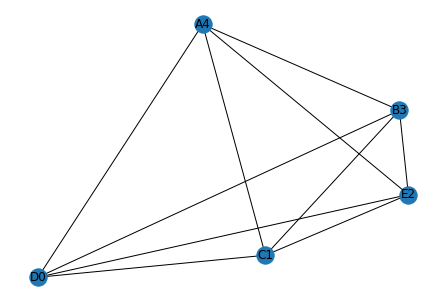

In [18]:
G = nx.from_numpy_matrix(distances)
pos= nx.spiral_layout(G) 
nx.draw(G, pos, labels=graph_labels)